100%|██████████| 50/50 [00:01<00:00, 25.14it/s]


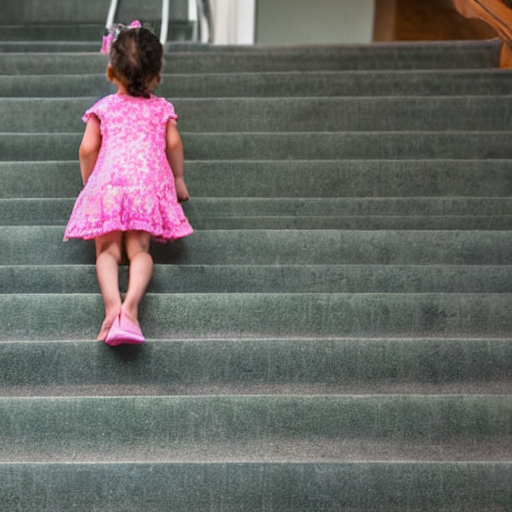

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

# Define the prompt
prompt = "A child in a pink dress is climbing up a set of stairs in an entry way"

# Generate the image
image = pipe(prompt).images[0]

# Display the image
display(image)


In [1]:
import torch
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, Subset
from torchmetrics.image.fid import FrechetInceptionDistance
from diffusers import StableDiffusionPipeline
from torchvision import transforms
import numpy as np
import time
import os
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
import pandas as pd

# Configurations
device = "cuda" if torch.cuda.is_available() else "cpu"
images_dir = "/home/node/academic/lcmlora/images"
eval_csv_path = "/home/node/academic/lcmlora/eval_data.csv"
num_samples = None

# TensorBoard Initialization
log_dir = "runs/basemodel"
writer = SummaryWriter(log_dir)

# Load Base Model
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None,
).to(device)

# Custom Dataset
class Flickr8kCSVDataset(Dataset):
    def __init__(self, csv_file, images_dir):
        self.data = pd.read_csv(csv_file)
        self.images_dir = images_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        image_path = os.path.join(self.images_dir, img_name)
        prompt = self.data.iloc[idx, 1]

        image = Image.open(image_path).convert("RGB")
        image = transforms.ToTensor()(image)
        return image, prompt, image_path

# Function to calculate FID
def calculate_fid(model, dataset, writer, num_samples=None):
    if num_samples is None or num_samples > len(dataset):
        num_samples = len(dataset)

    subset_indices = np.random.choice(len(dataset), num_samples, replace=False)
    subset = Subset(dataset, subset_indices)

    real_images = []
    generated_images = []
    total_inference_time = 0

    for i in range(num_samples):
        print(f"Processing image {i + 1}/{num_samples}")
        real_image, prompt, image_path = subset[i]

        start_time = time.time()
        print("Generating image...")
        generated_image = model(prompt).images[0]
        print("Image generated.")

        end_time = time.time()
        inference_time = end_time - start_time
        total_inference_time += inference_time

        print("Processing generated image...")
        generated_image = transforms.ToTensor()(generated_image)
        generated_image = transforms.Resize((299, 299))(generated_image)
        print("Generated image processed.")

        print("Processing real image...")
        real_image = transforms.functional.center_crop(real_image, (400, 400))
        real_image = transforms.Resize((299, 299))(real_image)
        print("Real image processed.")

        real_images.append(real_image)
        generated_images.append(generated_image)
        print(f"Iteration {i + 1}/{num_samples} completed.")

    real_images = torch.stack(real_images) * 255
    generated_images = torch.stack(generated_images) * 255

    real_images = real_images.to(torch.uint8).to(device)
    generated_images = generated_images.to(torch.uint8).to(device)

    print("Calculating FID...")
    fid = FrechetInceptionDistance(feature=64).to(device)
    fid.update(real_images, real=True)
    fid.update(generated_images, real=False)
    fid_value = fid.compute()
    print(f"FID: {fid_value.item():.2f}")

    writer.add_scalar("FID", fid_value.item(), 0)
    average_inference_time = total_inference_time / num_samples
    print(f"Average Inference Time: {average_inference_time:.4f} seconds")

# --- Main Execution ---
dataset = Flickr8kCSVDataset(eval_csv_path, images_dir)
calculate_fid(pipe, dataset, writer, num_samples)
writer.close()

/home/node/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-11 18:48:12.923816: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-11 18:48:13.364870: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 18:48:14.194152: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/nod

Processing image 1/100
Generating image...


100%|██████████| 50/50 [00:02<00:00, 21.15it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 1/100 completed.
Processing image 2/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.24it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 2/100 completed.
Processing image 3/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.21it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 3/100 completed.
Processing image 4/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.25it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 4/100 completed.
Processing image 5/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.39it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 5/100 completed.
Processing image 6/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.39it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 6/100 completed.
Processing image 7/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.28it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 7/100 completed.
Processing image 8/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.21it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 8/100 completed.
Processing image 9/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.20it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 9/100 completed.
Processing image 10/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.43it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 10/100 completed.
Processing image 11/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.31it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 11/100 completed.
Processing image 12/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.37it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 12/100 completed.
Processing image 13/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.30it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 13/100 completed.
Processing image 14/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.25it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 14/100 completed.
Processing image 15/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.19it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 15/100 completed.
Processing image 16/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.39it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 16/100 completed.
Processing image 17/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.34it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 17/100 completed.
Processing image 18/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.28it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 18/100 completed.
Processing image 19/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.36it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 19/100 completed.
Processing image 20/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.25it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 20/100 completed.
Processing image 21/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.20it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 21/100 completed.
Processing image 22/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.36it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 22/100 completed.
Processing image 23/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.39it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 23/100 completed.
Processing image 24/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.24it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 24/100 completed.
Processing image 25/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.34it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 25/100 completed.
Processing image 26/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.33it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 26/100 completed.
Processing image 27/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.36it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 27/100 completed.
Processing image 28/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.40it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 28/100 completed.
Processing image 29/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.30it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 29/100 completed.
Processing image 30/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.35it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 30/100 completed.
Processing image 31/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.41it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 31/100 completed.
Processing image 32/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.36it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 32/100 completed.
Processing image 33/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.38it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 33/100 completed.
Processing image 34/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.44it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 34/100 completed.
Processing image 35/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.36it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 35/100 completed.
Processing image 36/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.26it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 36/100 completed.
Processing image 37/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.23it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 37/100 completed.
Processing image 38/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.32it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 38/100 completed.
Processing image 39/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.28it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 39/100 completed.
Processing image 40/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.30it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 40/100 completed.
Processing image 41/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.32it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 41/100 completed.
Processing image 42/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.35it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 42/100 completed.
Processing image 43/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.36it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 43/100 completed.
Processing image 44/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.33it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 44/100 completed.
Processing image 45/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.35it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 45/100 completed.
Processing image 46/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.31it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 46/100 completed.
Processing image 47/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.33it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 47/100 completed.
Processing image 48/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.38it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 48/100 completed.
Processing image 49/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.31it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 49/100 completed.
Processing image 50/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.31it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 50/100 completed.
Processing image 51/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.26it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 51/100 completed.
Processing image 52/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.34it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 52/100 completed.
Processing image 53/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.27it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 53/100 completed.
Processing image 54/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.35it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 54/100 completed.
Processing image 55/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.29it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 55/100 completed.
Processing image 56/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.14it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 56/100 completed.
Processing image 57/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.07it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 57/100 completed.
Processing image 58/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.11it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 58/100 completed.
Processing image 59/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.04it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 59/100 completed.
Processing image 60/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.16it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 60/100 completed.
Processing image 61/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.08it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 61/100 completed.
Processing image 62/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.12it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 62/100 completed.
Processing image 63/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.03it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 63/100 completed.
Processing image 64/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.12it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 64/100 completed.
Processing image 65/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.06it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 65/100 completed.
Processing image 66/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.10it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 66/100 completed.
Processing image 67/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.03it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 67/100 completed.
Processing image 68/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.01it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 68/100 completed.
Processing image 69/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.07it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 69/100 completed.
Processing image 70/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.15it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 70/100 completed.
Processing image 71/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.11it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 71/100 completed.
Processing image 72/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.11it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 72/100 completed.
Processing image 73/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.17it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 73/100 completed.
Processing image 74/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.22it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 74/100 completed.
Processing image 75/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.26it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 75/100 completed.
Processing image 76/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.27it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 76/100 completed.
Processing image 77/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.20it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 77/100 completed.
Processing image 78/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.20it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 78/100 completed.
Processing image 79/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.30it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 79/100 completed.
Processing image 80/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.16it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 80/100 completed.
Processing image 81/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.25it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 81/100 completed.
Processing image 82/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.27it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 82/100 completed.
Processing image 83/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.24it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 83/100 completed.
Processing image 84/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.25it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 84/100 completed.
Processing image 85/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.31it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 85/100 completed.
Processing image 86/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.22it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 86/100 completed.
Processing image 87/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.18it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 87/100 completed.
Processing image 88/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.20it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 88/100 completed.
Processing image 89/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.29it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 89/100 completed.
Processing image 90/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.20it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 90/100 completed.
Processing image 91/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.22it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 91/100 completed.
Processing image 92/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.21it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 92/100 completed.
Processing image 93/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.22it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 93/100 completed.
Processing image 94/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.22it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 94/100 completed.
Processing image 95/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.31it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 95/100 completed.
Processing image 96/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.24it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 96/100 completed.
Processing image 97/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.19it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 97/100 completed.
Processing image 98/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.05it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 98/100 completed.
Processing image 99/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.20it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 99/100 completed.
Processing image 100/100
Generating image...


100%|██████████| 50/50 [00:01<00:00, 25.22it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 100/100 completed.
Calculating FID...
FID: 1.68
Average Inference Time: 2.0731 seconds


In [6]:
import random
import pandas as pd
import torch
import torchvision
from torchvision.io import read_image
from torchmetrics.image.fid import FrechetInceptionDistance
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [7]:
eval_data = pd.read_csv("./data/eval_data.csv")
files = eval_data["file_name"].tolist()
prompts = eval_data["caption"].tolist()

In [9]:
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.unet.load_attn_procs("./output_lora/pytorch_lora_weights.safetensors")
pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.29.0.dev0",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


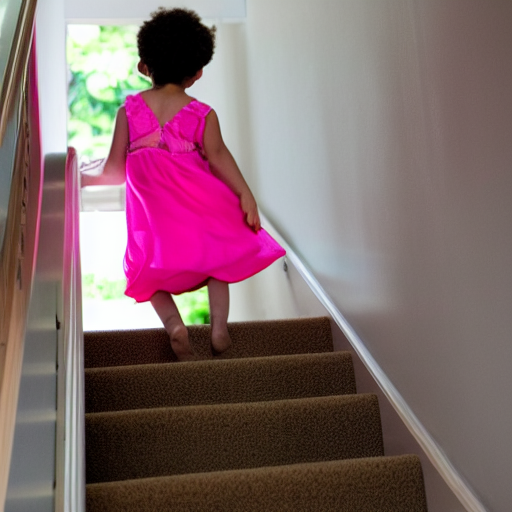

In [10]:
image = pipe("A child in a pink dress is climbing up a set of stairs in an entry way", num_inference_steps=50, guidance_scale=7.5).images[0]
image

In [11]:
# generate images
for i, (file, prompt) in enumerate(zip(files, prompts)):
  fake_img = pipe(prompt, num_inference_steps=50).images[0]
  fake_img.save(f"./images/fake{i}.jpg")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [12]:
fake_images = []
real_images = []
for i, (file, prompt) in enumerate(zip(files, prompts)):
  fake_img = read_image(f"./images/fake{i}.jpg")
  fake_img = torchvision.transforms.functional.resize(fake_img, (299, 299))
  fake_images.append(fake_img)
  real_img = read_image(f"./data/Images/{file}")
  real_img = torchvision.transforms.functional.center_crop(real_img, 400)
  real_img = torchvision.transforms.functional.resize(real_img, (299, 299))
  real_images.append(real_img)
fake_images = torch.stack(fake_images)
real_images = torch.stack(real_images)

In [13]:
fid = FrechetInceptionDistance(feature=64)
fid.update(fake_images, real=True)
fid.update(real_images, real=False)
fid.compute()

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 335MB/s]


tensor(1.4906)

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 10.99it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 30/30 [00:01<00:00, 25.43it/s]


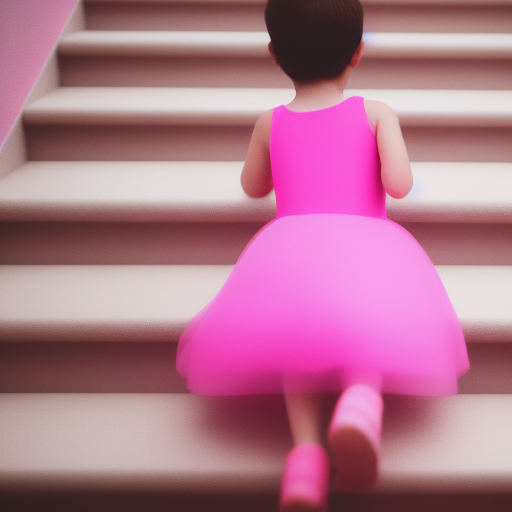

In [ ]:
import torch
from diffusers import StableDiffusionPipeline, LCMScheduler

# 1. Load Base Model and Scheduler
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None,  # Disable Safety Checker
)
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 2. Load Your LCM LoRA
pipe.load_lora_weights(
    "/home/node/academic/lcmlora/outputf30k/outputs"
)
pipe.fuse_lora()
# 3. Inference Settings
#prompt = "A child in a pink dress is climbing up a set of stairs in an entry way"
prompt = "A child in a pink dress is climbing up a set of stairs in an entry way"

num_inference_steps = 30  # LCM typically uses fewer steps
guidance_scale = 7.5   # Lower guidance is recommended

# 4. Generate Image
image = pipe(prompt, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale).images[0]
image.show()


In [ ]:
import torch
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, Subset
from torchmetrics.image.fid import FrechetInceptionDistance
from diffusers import StableDiffusionPipeline, LCMScheduler
from torchvision import transforms
import numpy as np
import time
import os
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
import pandas as pd

# Configurations
device = "cuda" if torch.cuda.is_available() else "cpu"
num_inference_steps = 20
guidance_scale = 7.5
images_dir = "/home/node/academic/lcmlora/images"
lora_weights_path = "/home/node/academic/lcm/outputs"
batch_size = 1
log_dir = "runs/lora_fid"
eval_csv_path = "/home/node/academic/lcmlora/eval_data.csv"  # Path to your CSV file
num_samples = None # Set a specific number or None to use the entire dataset

# TensorBoard Initialization
writer = SummaryWriter(log_dir)

# Load Models
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None,
)
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(device)

# Load LoRA Weights
pipe.load_lora_weights(lora_weights_path)
pipe.fuse_lora()

# Custom Dataset
class Flickr8kCSVDataset(Dataset):
    def __init__(self, csv_file, images_dir):
        self.data = pd.read_csv(csv_file)
        self.images_dir = images_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        image_path = os.path.join(self.images_dir, img_name)
        prompt = self.data.iloc[idx, 1]

        image = Image.open(image_path).convert("RGB")
        image = transforms.ToTensor()(image)
        return image, prompt, image_path

# Function to calculate FID
def calculate_fid(model, dataset, writer, num_samples=None):
    if num_samples is None or num_samples > len(dataset):
        num_samples = len(dataset)

    subset_indices = np.random.choice(len(dataset), num_samples, replace=False)
    subset = Subset(dataset, subset_indices)

    real_images = []
    generated_images = []
    inference_times = []

    for i in range(num_samples):
        print(f"Processing image {i + 1}/{num_samples}")
        real_image, prompt, image_path = subset[i]

        print("Generating image...")
        start_time = time.time()
        generated_image = model(prompt, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale).images[0]
        end_time = time.time()
        inference_time = end_time - start_time
        inference_times.append(inference_time)
        print("Image generated.")

        print("Processing generated image...")
        generated_image = transforms.ToTensor()(generated_image)
        generated_image = transforms.Resize((299, 299))(generated_image)
        print("Generated image processed.")

        print("Processing real image...")
        real_image = transforms.functional.center_crop(real_image, (400, 400))
        real_image = transforms.Resize((299, 299))(real_image)
        print("Real image processed.")

        real_images.append(real_image)
        generated_images.append(generated_image)
        print(f"Iteration {i + 1}/{num_samples} completed.")

    real_images = torch.stack(real_images) * 255
    generated_images = torch.stack(generated_images) * 255

    real_images = real_images.to(torch.uint8).to(device)
    generated_images = generated_images.to(torch.uint8).to(device)

    print("Calculating FID...")
    fid = FrechetInceptionDistance(feature=64).to(device)
    fid.update(real_images, real=True)
    fid.update(generated_images, real=False)
    fid_value = fid.compute()
    print(f"FID: {fid_value.item():.2f}")

    avg_inference_time = np.mean(inference_times)
    print(f"Average Inference Time per Image: {avg_inference_time:.2f} seconds")

    writer.add_scalar("FID", fid_value.item(), 0)
    writer.add_scalar("Average Inference Time", avg_inference_time, 0)

# Main Execution
dataset = Flickr8kCSVDataset(eval_csv_path, images_dir)

# Use the specified num_samples or the entire dataset if None
calculate_fid(pipe, dataset, writer, num_samples)
writer.close()

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 10.01it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Processing image 1/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.55it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 1/100 completed.
Processing image 2/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.37it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 2/100 completed.
Processing image 3/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.78it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 3/100 completed.
Processing image 4/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.69it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 4/100 completed.
Processing image 5/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.73it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 5/100 completed.
Processing image 6/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.86it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 6/100 completed.
Processing image 7/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.73it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 7/100 completed.
Processing image 8/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.79it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 8/100 completed.
Processing image 9/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.47it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 9/100 completed.
Processing image 10/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.52it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 10/100 completed.
Processing image 11/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.69it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 11/100 completed.
Processing image 12/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.54it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 12/100 completed.
Processing image 13/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.62it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 13/100 completed.
Processing image 14/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.61it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 14/100 completed.
Processing image 15/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.89it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 15/100 completed.
Processing image 16/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.68it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 16/100 completed.
Processing image 17/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.57it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 17/100 completed.
Processing image 18/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.68it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 18/100 completed.
Processing image 19/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.64it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 19/100 completed.
Processing image 20/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.73it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 20/100 completed.
Processing image 21/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.82it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 21/100 completed.
Processing image 22/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.96it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 22/100 completed.
Processing image 23/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.82it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 23/100 completed.
Processing image 24/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.61it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 24/100 completed.
Processing image 25/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.94it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 25/100 completed.
Processing image 26/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.52it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 26/100 completed.
Processing image 27/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.78it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 27/100 completed.
Processing image 28/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.55it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 28/100 completed.
Processing image 29/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.77it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 29/100 completed.
Processing image 30/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.57it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 30/100 completed.
Processing image 31/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.30it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 31/100 completed.
Processing image 32/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.66it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 32/100 completed.
Processing image 33/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.60it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 33/100 completed.
Processing image 34/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.68it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 34/100 completed.
Processing image 35/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.61it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 35/100 completed.
Processing image 36/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.60it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 36/100 completed.
Processing image 37/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.75it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 37/100 completed.
Processing image 38/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.50it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 38/100 completed.
Processing image 39/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.47it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 39/100 completed.
Processing image 40/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.81it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 40/100 completed.
Processing image 41/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.67it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 41/100 completed.
Processing image 42/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.70it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 42/100 completed.
Processing image 43/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.47it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 43/100 completed.
Processing image 44/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.63it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 44/100 completed.
Processing image 45/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.65it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 45/100 completed.
Processing image 46/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.65it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 46/100 completed.
Processing image 47/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.79it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 47/100 completed.
Processing image 48/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.74it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 48/100 completed.
Processing image 49/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.71it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 49/100 completed.
Processing image 50/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.62it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 50/100 completed.
Processing image 51/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.65it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 51/100 completed.
Processing image 52/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.67it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 52/100 completed.
Processing image 53/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.57it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 53/100 completed.
Processing image 54/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.44it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 54/100 completed.
Processing image 55/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.50it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 55/100 completed.
Processing image 56/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.66it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 56/100 completed.
Processing image 57/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.61it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 57/100 completed.
Processing image 58/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.52it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 58/100 completed.
Processing image 59/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.55it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 59/100 completed.
Processing image 60/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.56it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 60/100 completed.
Processing image 61/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.64it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 61/100 completed.
Processing image 62/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.74it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 62/100 completed.
Processing image 63/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.57it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 63/100 completed.
Processing image 64/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.34it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 64/100 completed.
Processing image 65/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.48it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 65/100 completed.
Processing image 66/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.59it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 66/100 completed.
Processing image 67/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.62it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 67/100 completed.
Processing image 68/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.54it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 68/100 completed.
Processing image 69/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.73it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 69/100 completed.
Processing image 70/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.54it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 70/100 completed.
Processing image 71/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.80it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 71/100 completed.
Processing image 72/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.75it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 72/100 completed.
Processing image 73/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.48it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 73/100 completed.
Processing image 74/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.62it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 74/100 completed.
Processing image 75/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.52it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 75/100 completed.
Processing image 76/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.71it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 76/100 completed.
Processing image 77/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.89it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 77/100 completed.
Processing image 78/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.82it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 78/100 completed.
Processing image 79/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.70it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 79/100 completed.
Processing image 80/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.77it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 80/100 completed.
Processing image 81/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.89it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 81/100 completed.
Processing image 82/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.80it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 82/100 completed.
Processing image 83/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.60it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 83/100 completed.
Processing image 84/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.85it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 84/100 completed.
Processing image 85/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.84it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 85/100 completed.
Processing image 86/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.78it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 86/100 completed.
Processing image 87/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.69it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 87/100 completed.
Processing image 88/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.90it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 88/100 completed.
Processing image 89/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.68it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 89/100 completed.
Processing image 90/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.72it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 90/100 completed.
Processing image 91/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.65it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 91/100 completed.
Processing image 92/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.85it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 92/100 completed.
Processing image 93/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.62it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 93/100 completed.
Processing image 94/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.75it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 94/100 completed.
Processing image 95/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.77it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 95/100 completed.
Processing image 96/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.59it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 96/100 completed.
Processing image 97/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.66it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 97/100 completed.
Processing image 98/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.76it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 98/100 completed.
Processing image 99/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.91it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 99/100 completed.
Processing image 100/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.79it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 100/100 completed.
Calculating FID...
FID: 26.95
Average Inference Time per Image: 0.86 seconds


In [ ]:
new_lora_weights_path = "/home/node/academic/lcmlora/outputf30k/outputs"
num_samples = None # Change as needed
guidance_scale = 10 # Change as needed
num_inference_steps = 20 # Change as needed

# --- Load LoRA and Evaluate ---

# Load LoRA Weights
pipe.load_lora_weights(new_lora_weights_path)
pipe.fuse_lora()

# Set up TensorBoard with a descriptive name
log_dir = f"runs/flickr30k_{os.path.basename(new_lora_weights_path)}"
writer = SummaryWriter(log_dir)

# Calculate FID and log
calculate_fid(pipe, dataset, writer, num_samples)
writer.close()

The current API is supported for operating with a single LoRA file. You are trying to load and fuse more than one LoRA which is not well-supported.


Processing image 1/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 21.14it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 1/100 completed.
Processing image 2/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.73it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 2/100 completed.
Processing image 3/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.78it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 3/100 completed.
Processing image 4/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.85it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 4/100 completed.
Processing image 5/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.66it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 5/100 completed.
Processing image 6/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.61it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 6/100 completed.
Processing image 7/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.61it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 7/100 completed.
Processing image 8/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.58it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 8/100 completed.
Processing image 9/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.63it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 9/100 completed.
Processing image 10/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.61it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 10/100 completed.
Processing image 11/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.72it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 11/100 completed.
Processing image 12/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.73it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 12/100 completed.
Processing image 13/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.64it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 13/100 completed.
Processing image 14/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.50it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 14/100 completed.
Processing image 15/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.42it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 15/100 completed.
Processing image 16/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.55it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 16/100 completed.
Processing image 17/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.81it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 17/100 completed.
Processing image 18/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.31it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 18/100 completed.
Processing image 19/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.62it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 19/100 completed.
Processing image 20/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.74it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 20/100 completed.
Processing image 21/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.58it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 21/100 completed.
Processing image 22/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.55it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 22/100 completed.
Processing image 23/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.64it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 23/100 completed.
Processing image 24/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.50it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 24/100 completed.
Processing image 25/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.20it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 25/100 completed.
Processing image 26/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.46it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 26/100 completed.
Processing image 27/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.61it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 27/100 completed.
Processing image 28/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.53it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 28/100 completed.
Processing image 29/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.45it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 29/100 completed.
Processing image 30/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.46it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 30/100 completed.
Processing image 31/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.50it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 31/100 completed.
Processing image 32/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.80it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 32/100 completed.
Processing image 33/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.69it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 33/100 completed.
Processing image 34/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.75it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 34/100 completed.
Processing image 35/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.84it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 35/100 completed.
Processing image 36/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.89it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 36/100 completed.
Processing image 37/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.94it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 37/100 completed.
Processing image 38/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.92it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 38/100 completed.
Processing image 39/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.76it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 39/100 completed.
Processing image 40/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.84it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 40/100 completed.
Processing image 41/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.75it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 41/100 completed.
Processing image 42/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.82it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 42/100 completed.
Processing image 43/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.91it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 43/100 completed.
Processing image 44/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.85it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 44/100 completed.
Processing image 45/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.91it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 45/100 completed.
Processing image 46/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.85it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 46/100 completed.
Processing image 47/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.91it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 47/100 completed.
Processing image 48/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.76it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 48/100 completed.
Processing image 49/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.82it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 49/100 completed.
Processing image 50/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.83it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 50/100 completed.
Processing image 51/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.74it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 51/100 completed.
Processing image 52/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.71it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 52/100 completed.
Processing image 53/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.62it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 53/100 completed.
Processing image 54/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.84it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 54/100 completed.
Processing image 55/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.66it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 55/100 completed.
Processing image 56/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.64it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 56/100 completed.
Processing image 57/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.72it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 57/100 completed.
Processing image 58/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.84it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 58/100 completed.
Processing image 59/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.81it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 59/100 completed.
Processing image 60/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.90it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 60/100 completed.
Processing image 61/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.80it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 61/100 completed.
Processing image 62/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.81it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 62/100 completed.
Processing image 63/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.57it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 63/100 completed.
Processing image 64/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.71it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 64/100 completed.
Processing image 65/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.86it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 65/100 completed.
Processing image 66/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.76it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 66/100 completed.
Processing image 67/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.83it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 67/100 completed.
Processing image 68/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.82it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 68/100 completed.
Processing image 69/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.86it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 69/100 completed.
Processing image 70/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.69it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 70/100 completed.
Processing image 71/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.63it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 71/100 completed.
Processing image 72/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.86it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 72/100 completed.
Processing image 73/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.77it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 73/100 completed.
Processing image 74/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.86it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 74/100 completed.
Processing image 75/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.79it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 75/100 completed.
Processing image 76/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.78it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 76/100 completed.
Processing image 77/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.62it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 77/100 completed.
Processing image 78/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.54it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 78/100 completed.
Processing image 79/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.73it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 79/100 completed.
Processing image 80/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.63it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 80/100 completed.
Processing image 81/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.69it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 81/100 completed.
Processing image 82/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.76it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 82/100 completed.
Processing image 83/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.60it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 83/100 completed.
Processing image 84/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.78it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 84/100 completed.
Processing image 85/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.75it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 85/100 completed.
Processing image 86/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.54it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 86/100 completed.
Processing image 87/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.70it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 87/100 completed.
Processing image 88/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.56it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 88/100 completed.
Processing image 89/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.75it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 89/100 completed.
Processing image 90/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.64it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 90/100 completed.
Processing image 91/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.72it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 91/100 completed.
Processing image 92/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.66it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 92/100 completed.
Processing image 93/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.74it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 93/100 completed.
Processing image 94/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.58it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 94/100 completed.
Processing image 95/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.71it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 95/100 completed.
Processing image 96/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.56it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 96/100 completed.
Processing image 97/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.66it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 97/100 completed.
Processing image 98/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.72it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 98/100 completed.
Processing image 99/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.74it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 99/100 completed.
Processing image 100/100
Generating image...


100%|██████████| 20/20 [00:00<00:00, 25.68it/s]


Image generated.
Processing generated image...
Generated image processed.
Processing real image...
Real image processed.
Iteration 100/100 completed.
Calculating FID...
FID: 24.85
Average Inference Time per Image: 0.86 seconds
